## Notebook contains model to detect Collisions in NYC

This Notebook has various Forecast models using advanced Machine Learning techniques, to predict the possible collisions in the city. The model is finalized based on the least RMSE.

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/accidents_with_prediction.csv')

In [5]:
df['borough'].value_counts()

MANHATTAN        51346
BROOKLYN         32397
QUEENS           31040
BRONX            18085
STATEN ISLAND     4238
Name: borough, dtype: int64

**Taking Manhattan data for for the Time-Series Model**

In [6]:
df1 = df[df['borough'] == 'MANHATTAN']

In [7]:
def extract_ddy(date):
    dd = date.split(' ')
    year_month = dd[0][:7]
    year_month_day = dd[0]
    year = int(year_month[:4])
    month = int(year_month[5:7])
    hour = int(dd[1][:2])
    return year_month_day, year, month, hour

In [8]:
df1 = df1.reset_index().iloc[:, 1:]

In [9]:
ym, y, m, h = [], [], [], []

for i in range(len(df1)):
    a, b, c, d= extract_ddy(df1.timestamp[i])
    ym.append(a)
    y.append(b)
    m.append(c)
    h.append(d)
    
df1['date'] = ym
df1['year'] = y
df1['month'] = m
df1['hour'] = h

In [10]:
df1.set_index(df1['date'],inplace=True)

In [11]:
df2 = pd.DataFrame(df1['date'].value_counts())

In [12]:
df2.columns = ['count']

In [13]:
df2.index = pd.to_datetime(df2.index)

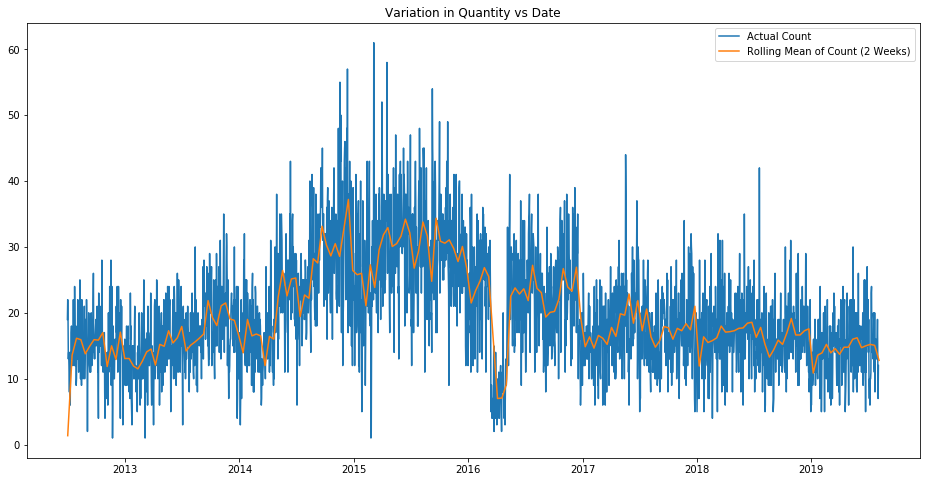

In [12]:
daily = df2['count'].resample('D').sum()
avg = df2['count'].resample('2W').sum()/14
avg.index = avg.index.shift(1, freq='D')

plt.figure(figsize=(16, 8))
plt.plot(daily, label='Actual Count')
plt.plot(avg, label='Rolling Mean of Count (2 Weeks)')
plt.title('Variation in Quantity vs Date')
plt.legend()
plt.show()

In [13]:
errors = pd.Series(avg - daily).fillna(method='ffill')
print('RMSE if Two-week Average is predicted: {}'.format((errors**2).mean()**.5))

RMSE if Two-week Average is predicted: 5.718051365416368


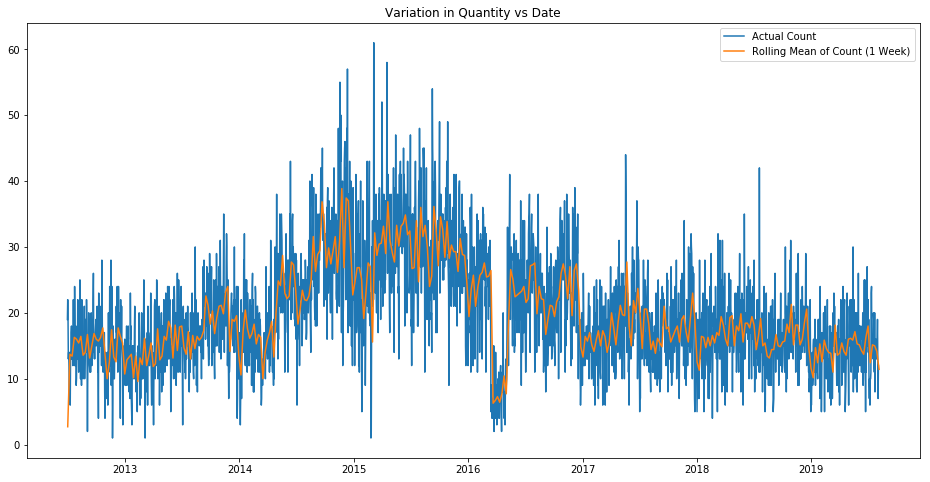

In [14]:
daily = df2['count'].resample('D').sum()
avg = df2['count'].resample('W').sum()/7
avg.index = avg.index.shift(1, freq='D')

plt.figure(figsize=(16, 8))
plt.plot(daily, label='Actual Count')
plt.plot(avg, label='Rolling Mean of Count (1 Week)')
plt.title('Variation in Quantity vs Date')
plt.legend()
plt.show()

In [15]:
errors = pd.Series(avg - daily).fillna(method='ffill')
print('RMSE if One-week Average is predicted: {}'.format((errors**2).mean()**.5))

RMSE if One-week Average is predicted: 5.949256837809942


**Taking the average of last week also gives us a pretty good intution of the collisions in the upcoming weeks. RMSE of two-week average is lower than that of one-week average, hence taking that as the baseline model. Let's try various ML models if they can do better than the baselines one week Model.**

In [14]:
daily = df2['count'].resample('D').sum()

**Statsmodels**

In [15]:
from statsmodels.tsa.arima_model import ARIMA, AR
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pandas.plotting import autocorrelation_plot
import statistics as st
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#### Autocorrelation and partial Autocorrelation to check the relationship between consecutive data in time-series

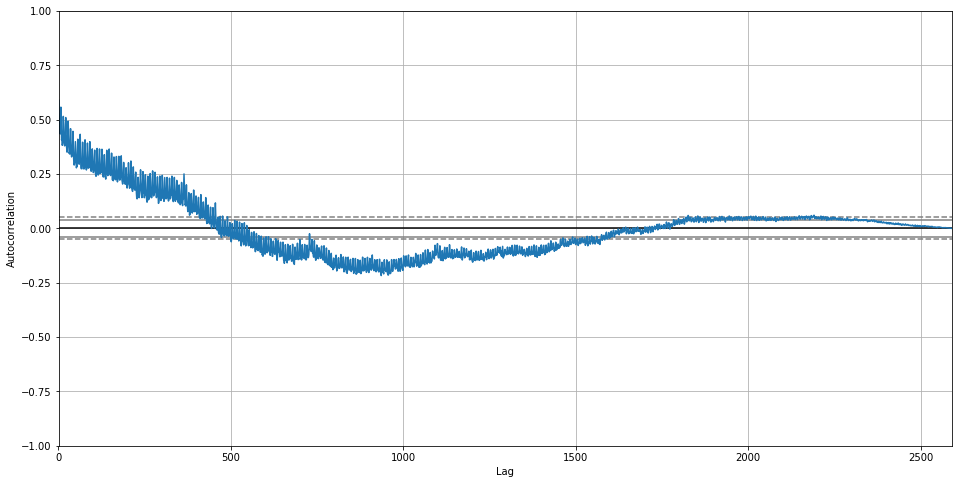

In [18]:
plt.figure(figsize=(16, 8))
autocorrelation_plot(daily)
plt.show()

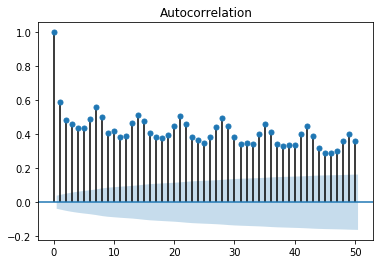

In [19]:
plot_acf(daily, lags=50)
plt.show()

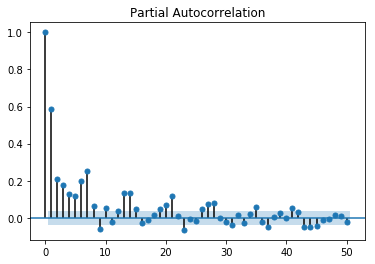

In [20]:
plot_pacf(daily, lags=50)
plt.show()

We see high autocorelation and partial autocorrelation with lag=1.

### ML Models

**1. ARIMA Model (Univariate)**

Auto-Regressive Integrated Moving Average Model for Time-series Prediction

The model uses the dependent relationship between an observation and some number of lagged observations. The use of differencing of raw observations in order to make the time-series stationary. **A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.**

Parameters of the ARIMA Model:   
p: Lag Order. No of lag observations included in the model   
d: Degree of Differencing. The no of times that the raw observations are differenced.   
q: Order of moving Average. The size of the moving avg window.

In [16]:
length = int(daily.shape[0]*0.8)
train = daily.iloc[:length]
test = daily.iloc[length:]
train.shape, test.shape

((2072,), (518,))

In [ ]:
history = train.values.tolist()
actual = []
forecasted = []

for t in range(0,len(test)):
    model = ARIMA(history, order=(1, 0, 2))
    model_fit = model.fit()
    output = model_fit.predict(len(history), len(history))
    yhat = output[0]
    forecasted.append(yhat)
    obs = test[t]
    actual.append(obs)
    history.append(obs)
    
plt.figure(figsize=(16,8))
plt.plot(actual, label = "Test Value")
plt.plot(forecasted, label = "Predicted Value")
plt.title("Predicted and Test values")
plt.legend()
plt.show()

In [ ]:
#actual, forecasted = np.array(actual), np.array(forecasted)
#print("RMSE: {:.1f}".format(((actual[:-1]-forecasted[:-1])**2).mean()**.5))
print("RMSE:",5.4)

**Trying the AR Model**

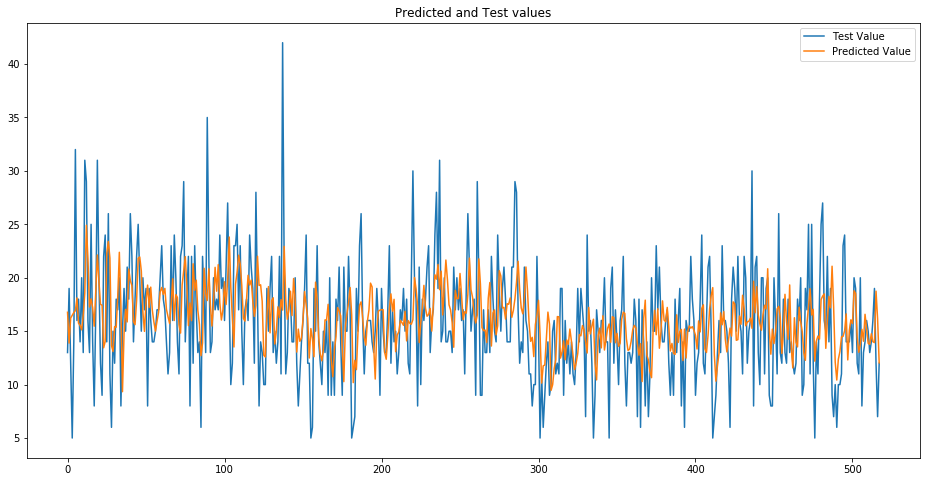

In [34]:
history = train.values.tolist()
actual = []
forecasted = []

for t in range(0,len(test)):
    model = AR(history)
    model_fit = model.fit()
    output = model_fit.predict(len(history), len(history))
    yhat = output[0]
    forecasted.append(yhat)
    obs = test[t]
    actual.append(obs)
    history.append(obs)
    
plt.figure(figsize=(16,8))
plt.plot(actual, label = "Test Value")
plt.plot(forecasted, label = "Predicted Value")
plt.title("Predicted and Test values")
plt.legend()
plt.show()

In [35]:
actual, forecasted = np.array(actual), np.array(forecasted)
print("RMSE: {:.1f}".format(((actual[:-1]-forecasted[:-1])**2).mean()**.5))

RMSE: 5.2


**We see that the AR Model performs better than the ARIMA Model.**

**2. FB-Prophet (Univariate)**

In [21]:
import fbprophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


Prophet takes data in a certain format, with dataframe of 2 columns, 'ds' and 'y' and remove the index and view the data

In [22]:
pdata = pd.DataFrame({"ds": daily.index, "y": daily})
pdata.reset_index(drop=True, inplace=True)

In [23]:
pmodel = fbprophet.Prophet(changepoint_prior_scale=0.95, weekly_seasonality=True)

In [36]:
pmodel.fit(pdata)
pforecast = pmodel.make_future_dataframe(periods=30, freq='D')
pforecast = pmodel.predict(pforecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
pd.plotting.register_matplotlib_converters()

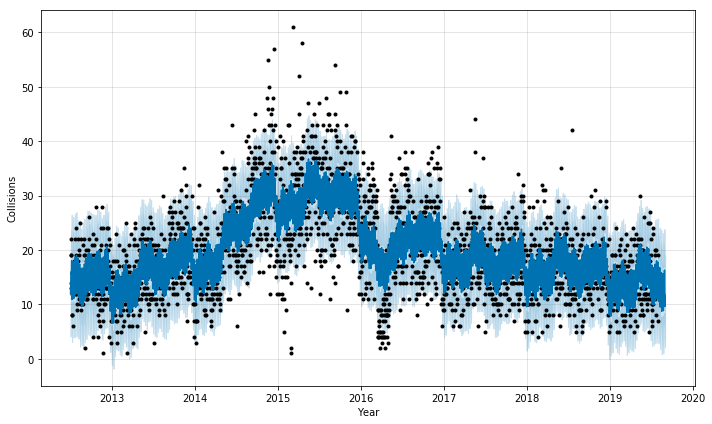

In [38]:
pmodel.plot(pforecast, xlabel='Year', ylabel ='Collisions');

Apply the cross validation on the prophet model and do the prediction, with initial as the train data, period as the rolling window and horizon will be the future forecast values. After the forecast values are obtained, "y" which is the actual number of Collisions, and 'yhat' which is the predicted value.

INFO:fbprophet:Making 352 forecasts with cutoffs between 2012-10-11 00:00:00 and 2019-07-04 00:00:00


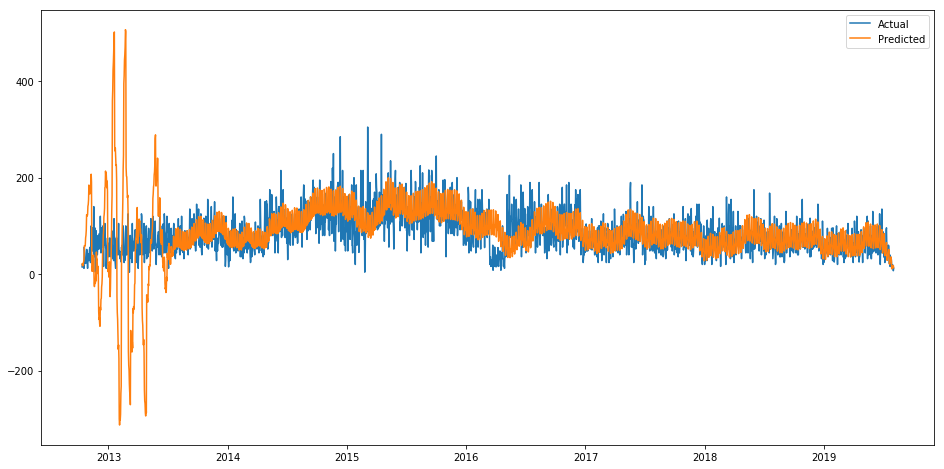

In [39]:
cdd_cv = cross_validation(pmodel, initial='100 days', period='7 days', horizon='30 days')
fbp_cdd = cdd_cv[['ds','y','yhat']].copy()
fbp_cdd['ds'] = pd.to_datetime(cdd_cv['ds'])
fbp_cdd = fbp_cdd.sort_values(by='ds')
fbp_cdd.set_index('ds', inplace=True)
fbp_cdd = fbp_cdd.resample('D').sum()

figx = plt.figure(figsize=(16,8))
plt.plot(fbp_cdd['y'], label='Actual')
plt.plot(fbp_cdd['yhat'], label='Predicted')
plt.legend()
plt.show()
figx;

In [40]:
print('RMSE = {}'.format((((cdd_cv.y - cdd_cv.yhat)**2).mean())**0.5))

RMSE = 26.906943220569502


#### The Prophet and ARIMA Models haven't performed so well. ARIMA Model in spite of giving low RMSE isn't so efficient as it takes really long time to come up with predictions. So, it's better to exclude that model.

**3. 1D CNN Model (Univariate Model)**

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU
from keras.layers import concatenate

Using TensorFlow backend.


In [42]:
#Reshape the data
train = np.array(daily.values)
train = train.reshape(-1, 1)

#Convert to test_train_split
x_train = []
y_train = []
for i in range(60, len(train)):
    x_train.append(train[i-60:i])
    y_train.append(train[i])

In [43]:
#Split the dataset
x_train, y_train = np.array(x_train), np.array(y_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [44]:
regressor = Sequential()
regressor.add(Conv1D(filters = 45, kernel_size = 14, activation = "relu", \
                     input_shape = (x_train.shape[1], 1), padding = "same"))
regressor.add(MaxPooling1D(pool_size=2))
regressor.add(Conv1D(filters = 45, kernel_size = 14, activation = "relu",
                     padding = "same"))
regressor.add(MaxPooling1D(pool_size=2))
regressor.add(Flatten())
regressor.add(Dense(50, activation='relu'))
regressor.add(Dense(1))
regressor.compile(optimizer = "adam", loss = "mse")

history = regressor.fit(x_train, y_train, epochs=10, batch_size = 32, verbose=0)

W0824 16:19:57.185895 140308600825600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 16:19:57.201694 140308600825600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 16:19:57.204353 140308600825600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 16:19:57.223725 140308600825600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0824 16:19:57.273699 140308600825600 deprecation_wrapp

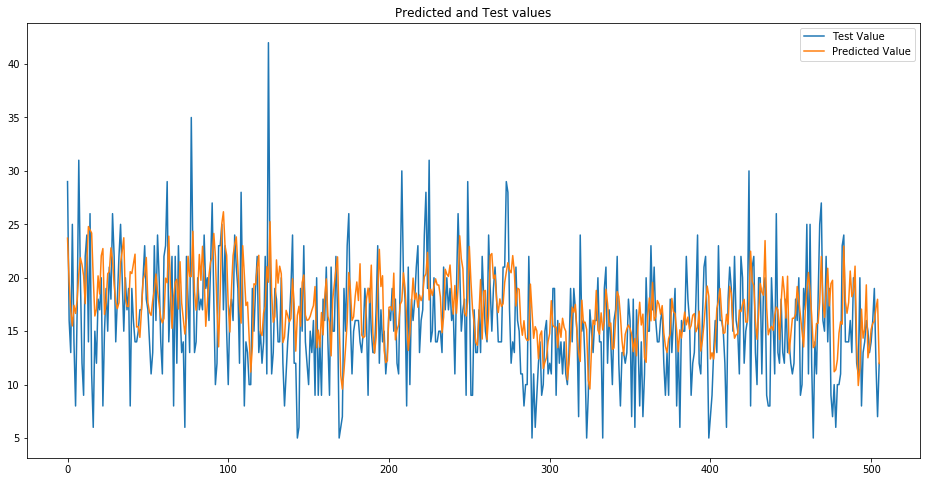

In [45]:
#Apply predict on Test data and get the forecast
predict = regressor.predict(x_test)
fig1 = plt.figure(figsize=(16,8))
plt.plot(y_test, label = "Test Value")
plt.plot(predict, label = "Predicted Value")
plt.title("Predicted and Test values")
plt.legend()
plt.show()
fig1;

In [46]:
print('RMSE = {}'.format((((predict - y_test)**2).mean())**0.5))

RMSE = 5.344230660591032


**4. CNN LSTM Model (Multivariate Model)**

In [47]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [48]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [49]:
daily = df2['count'].resample('D').sum()

In [50]:
# define input sequence
raw_seq = daily.values.tolist()
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

#Split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)


In [51]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=10, verbose=0)


W0824 16:20:06.849838 140308600825600 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


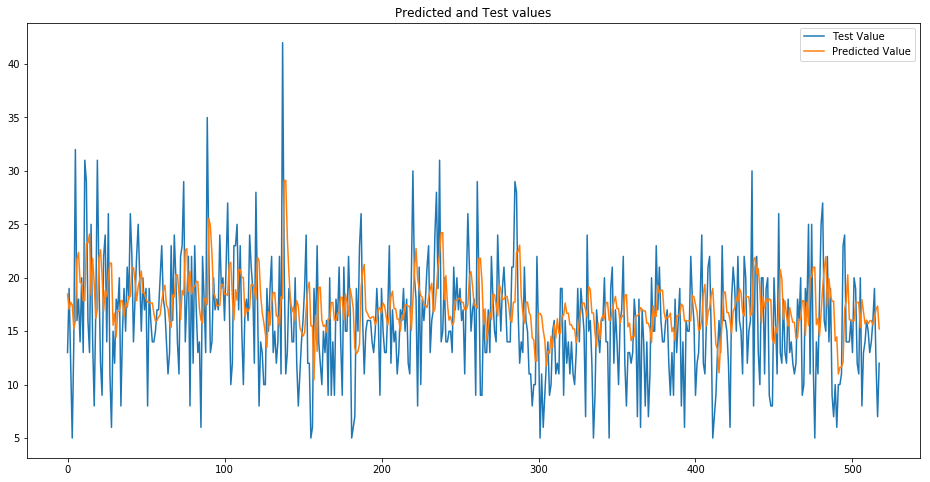

In [52]:
# demonstrate prediction
predict = model.predict(x_test)

fig3 = plt.figure(figsize=(16,8))
plt.plot(y_test, label = "Test Value")
plt.plot(predict, label = "Predicted Value")
plt.title("Predicted and Test values")
plt.legend()
plt.show()
fig3;

In [53]:
print('RMSE = {}'.format((((predict - y_test)**2).mean())**0.5))

RMSE = 6.047802648154775


**5. GRU Model (Univariate Model)**

In [20]:
np.random.seed(42)
train = np.array(daily.values)
train = train.reshape(-1,1)

x = []
y = []
for i in range(60, len(train)):
    x.append(train[i-60:i])
    y.append(train[i])
    
x, y = np.array(x), np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(GRU(60, input_shape = (x_train.shape[1], 1), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss = "mae", optimizer = "adam")
history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)

W0824 19:29:02.881379 140374968338176 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 19:29:03.115012 140374968338176 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 19:29:03.219317 140374968338176 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 19:29:03.520570 140374968338176 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 19:29:04.286051 140374968338176 deprecation.py:323

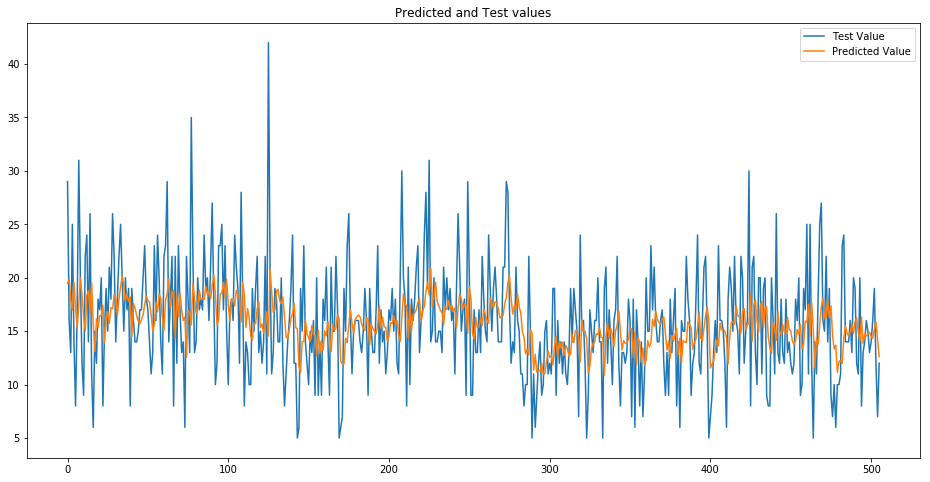

In [21]:
lstm_preds = model.predict(x_test)

fig2 = plt.figure(figsize=(16,8))
plt.plot(y_test, label = "Test Value")
plt.plot(lstm_preds, label = "Predicted Value")
plt.title("Predicted and Test values")
plt.legend()
plt.show()
fig2;

In [22]:
print('RMSE = {}'.format((((lstm_preds - y_test)**2).mean())**0.5))

RMSE = 6.257781854904109


## CNN 1D Model has outperformed all other models. It can be deployed and we can go ahead and check the model for other boroughs.